In [15]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [18]:
# 1.1. 填入 ??? 的部份

class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames # 資料集的所有檔名
        self.labels = labels # 影像的標籤
        self.transform = transform # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames) # return DataSet 長度
 
    def __getitem__(self, idx):
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) #??? # Transform image
        label = np.array(self.labels[idx])
                
        return image, label # return 模型訓練所需的資訊


In [19]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])
def split_Train_Val_Data(data_dir):
  dataset = ImageFolder(data_dir)

  # 建立 20 類的 list
  character = [[] for i in range(len(dataset.classes))]
  # print(character)

  # 將每一類的檔名依序存入相對應的 list
  for x, y in dataset.samples:
      character[y].append(x)#append each img X into diff label Y
    
  train_inputs, test_inputs = [], []
  train_labels, test_labels = [], []
  # print(len(character[3]))
  for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
      
      np.random.seed(42)
      np.random.shuffle(data)
      # -------------------------------------------
      # 將每一類都以 8:2 的比例分成訓練資料和測試資料
      # -------------------------------------------
      # print(int(len(data)/10)*8 ,int(len(data)/10)*8+1 )
      # print( type(character[i][data]))
      # print(character[i][])
      num_sample_train = int(len(data)/10)*8  #character[i][:int(len(data)/10)*8]
      num_sample_test = int(len(data)/10)*8+1 #character[i][int(len(data)/10)*8+1:]
      # print(data)
      for x in data[:num_sample_train] :# 前 80% 資料存進 training list
          train_inputs.append(x)
          train_labels.append(i) 

          
      for x in data[num_sample_test:] : # 後 20% 資料存進 testing list
          test_inputs.append(x)
          test_labels.append(i)

      train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                    batch_size = batch_size, shuffle = True)
      test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
                                    batch_size = batch_size, shuffle = False)
  
  return train_dataloader, test_dataloader

In [20]:
# 2.2. 自行設計一個新的 CNN model
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        
class DogBreedPretrainedVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.vgg16(pretrained=True)
        # Replace last layer  
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=120, bias=True),
           nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

class BuildModel(nn.Module):

    def __init__(self):
        super(BuildModel, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #2
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #3
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #4
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #5
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #6
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #7
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #8
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #9
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #10
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #11
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #12
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #13
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.AvgPool2d(kernel_size=1,stride=1),
            )
        self.classifier = nn.Sequential(
            #14
            nn.Linear(128*14*14,4096),
            nn.ReLU(True),
            nn.Dropout(),
            #15
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            #16
            nn.Linear(4096,20),
            )
        #??? # 初始化模型的 layer (input size: 3 * 224 * 224)
        # ----------------------------------------------
               
    def forward(self, x):
        # ----------------------------------------------
        #??? # Forward (最後輸出 20 個類別的機率值)
        out = self.features(x)
        # print(out.shape) 
        out = out.view(-1,128*14*14)
        # print(out.shape)
        out = self.classifier(out)

        # print(out.shape)
        # ----------------------------------------------
 
        return out #???

In [21]:
batch_size = 32
lr = 1e-3
epochs = 20

data_dir = '/content/drive/My Drive/ColabNotebooks/AI_HW3/stanford_dog'

In [22]:
# 2.3. 

train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

C = DogBreedPretrainedVGG16().to(device) # 使用內建的 model 或是自行設計的 model
optimizer_C = optim.SGD(C.parameters(), lr = lr) # 選擇你想用的 optimizer
summary(C, (3, 224, 224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

# Loss function
criterion = nn.CrossEntropyLoss() # 選擇想用的 loss function

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [23]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

In [24]:
if __name__ == '__main__':    
    
    for epoch in range(epochs):
    
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
                        
            optimizer_C.zero_grad() # 清空梯度
            
            output = C(x) # 將訓練資料輸入至模型進行訓練
            loss = criterion(output, label) # 計算 loss
            
            loss.backward() # 將 loss 反向傳播
            optimizer_C.step() # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(output,1)
            total_train += label.size(0) #???
            correct_train += (predicted == label).sum()

            train_loss_C += loss.item()
            iter +=  1
                    
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad(): # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                
                test_output = C(x) # 將測試資料輸入至模型進行測試
                #??? # 計算測試資料的準確度
                
                _, predicted = torch.max(test_output.data,1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum()
        
        print('Testing acc: %.3f' % (correct_test / total_test))
                                     
        train_acc.append(100 * (correct_train / total_train)) # training accuracy
        test_acc.append(100 * (correct_test / total_test) ) # testing accuracy
        loss_epoch_C.append(train_loss_C / len(train_dataloader)) # loss  

epoch: 1 / 20
Training epoch: 1 / loss_C: 4.085 | acc: 0.089
Testing acc: 0.324
epoch: 2 / 20
Training epoch: 2 / loss_C: 2.358 | acc: 0.284
Testing acc: 0.610
epoch: 3 / 20
Training epoch: 3 / loss_C: 1.713 | acc: 0.446
Testing acc: 0.750
epoch: 4 / 20
Training epoch: 4 / loss_C: 1.461 | acc: 0.524
Testing acc: 0.760
epoch: 5 / 20
Training epoch: 5 / loss_C: 1.294 | acc: 0.572
Testing acc: 0.755
epoch: 6 / 20
Training epoch: 6 / loss_C: 1.210 | acc: 0.591
Testing acc: 0.768
epoch: 7 / 20
Training epoch: 7 / loss_C: 1.141 | acc: 0.625
Testing acc: 0.795
epoch: 8 / 20
Training epoch: 8 / loss_C: 1.091 | acc: 0.634
Testing acc: 0.792
epoch: 9 / 20
Training epoch: 9 / loss_C: 1.053 | acc: 0.646
Testing acc: 0.805
epoch: 10 / 20
Training epoch: 10 / loss_C: 0.983 | acc: 0.672
Testing acc: 0.764
epoch: 11 / 20
Training epoch: 11 / loss_C: 0.967 | acc: 0.674
Testing acc: 0.785
epoch: 12 / 20
Training epoch: 12 / loss_C: 0.939 | acc: 0.682
Testing acc: 0.819
epoch: 13 / 20
Training epoch: 13 

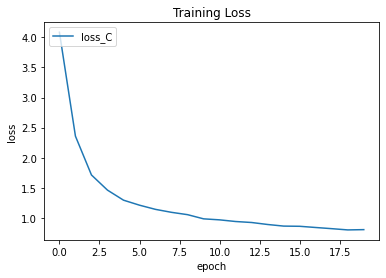

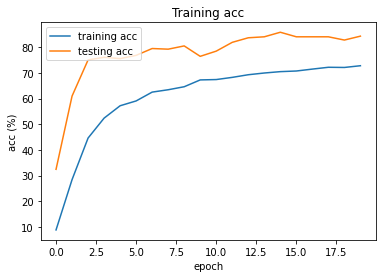

In [25]:
plt.figure()

plt.plot(loss_epoch_C) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.show()

plt.figure()

plt.plot(train_acc)#??? # plot your training accuracy
plt.plot(test_acc)#??? # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.show()